#### Load some package which we will use in this demo

In [1]:
%matplotlib inline
import scipy.stats
import scipy.spatial.distance as spdist
import numpy as np
from brainiak.reprsimil.brsa import BRSA
import brainiak.utils.utils as utils
import os.path
import numdifftools as nd
import matplotlib.pyplot as plt
import logging
np.random.seed(100)

#### You might want to keep a log of the output.

In [2]:
logging.basicConfig(level=logging.DEBUG, filename='test.log',
                    format='%(relativeCreated)6d %(threadName)s %(message)s')

# (1) We want to simulate some data in which each voxel respond to different task conditions differently, but following a common covariance structure

## Load an example design matrix.
The user should prepare their design matrix with their favorate software, such as using 3ddeconvolve of AFNI, or using SPM or FSL.
The design matrix reflects your belief of how fMRI signal should respond to a task (if a voxel does respond).
The common assumption is that a neural event that you are interested in will elicit a slow hemodynamic response in some voxels. The response peaks around 4-6 seconds after the event onset and dies down more than 12 seconds after the event. Therefore, typically you convolve a time series A, composed of delta (stem) functions reflecting the time of each neural event belonging to the same category (e.g. all trials in which a participant sees a face), with a hemodynamic response function B, to form the hypothetic response of any voxel to such type of neural event.
For each type of event, such a convoluted time course can be generated. These time courses, put together, are called design matrix, reflecting what we believe a temporal signal would look like, if it exists in any voxel.
Our goal is to figure out how the (spatial) response pattern of a population of voxels (in an Region of Interest, ROI) are similar or disimilar to different types of tasks (e.g., watching face vs. house, watching different categories of animals, different conditions of a cognitive task). So we need the design matrix in order to estimate the similarity matrix we are interested.

We can use the utility called ReadDesign to read a design matrix generated from AFNI. For design matrix saved as Matlab data file by SPM or or other toolbox, you can use scipy.io.loadmat('YOURFILENAME') and extract the design matrix from the dictionary returned. Basically, the Bayesian RSA in this toolkit just needs a numpy array which is in size of {time points} * {condition}

The design matrix we load in this demo has 16 different conditions. The baseline level in different voxels might be different even if you z-score the data. Therefore, we need to take into account possible different baseline. Currently, our method put an additional condition composed of all 1's (DC component) into the design matrix for this goal. Very soon, we will have a version which treats baseline level and other not interested signals shared across voxels separately from the signals we are interested in.
### We concatenate the design matrix by 2 times, mimicking 2 runs of itenditcal timing

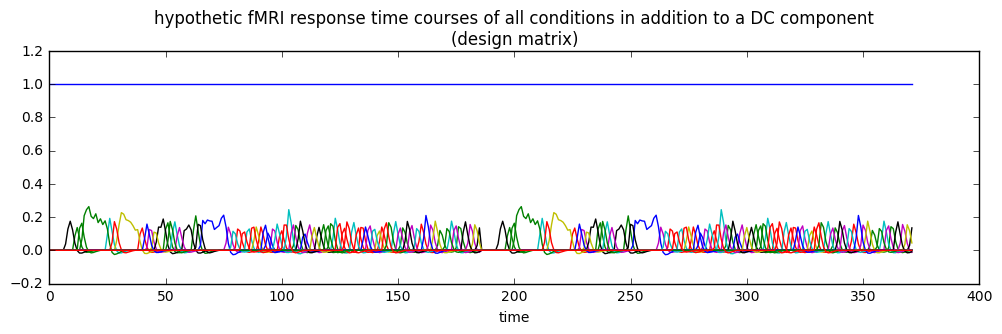

In [3]:
design = utils.ReadDesign(fname="example_design.1D")


design.design_used = np.tile(design.design_used[:,0:17],[2,1])
design.n_TR = design.n_TR * 2


fig = plt.figure(num=None, figsize=(12, 3), dpi=150, facecolor='w', edgecolor='k')

plt.plot(design.design_used)
plt.ylim([-0.2,1.2])
plt.title('hypothetic fMRI response time courses of all conditions in addition to a DC component\n'
         '(design matrix)')
plt.xlabel('time')
plt.show()

n_C = np.size(design.design_used,axis=1) 
# The total number of conditions.
ROI_edge = 25
# We simulate "ROI" of a square shape
n_V = ROI_edge**2
# The total number of simulated voxels
n_T = design.n_TR
# The total number of time points, after concatenating all fMRI runs


## simulate data: noise + signal
### First, we start with noise

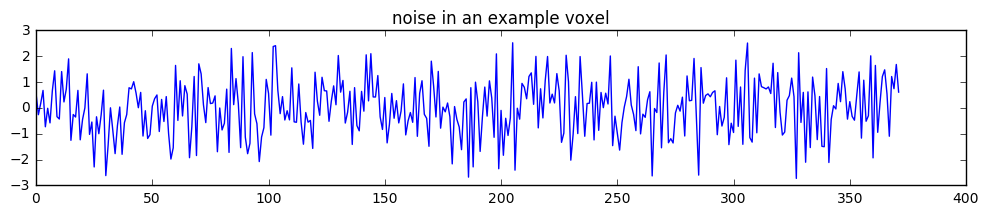

In [4]:
noise_bot = 0.5
noise_top = 1.5
noise_level = np.random.rand(n_V)*(noise_top-noise_bot)+noise_bot
# The standard deviation of the noise is in the range of [noise_bot, noise_top]
# In fact, we simulate autocorrelated noise with AR(1) model. So the noise_level reflects
# the independent additive noise at each time point (the "fresh" noise)

# AR(1) coefficient
rho1_top = 0.8
rho1_bot = -0.2
rho1 = np.random.rand(n_V)*(rho1_top-rho1_bot)+rho1_bot


# generating noise
noise = np.zeros([n_T,n_V])
noise[0,:] = np.random.randn(n_V) * noise_level / np.sqrt(1-rho1**2)
for i_t in range(1,n_T):
    noise[i_t,:] = noise[i_t-1,:] * rho1 +  np.random.randn(n_V) * noise_level
# Here, we assume noise is independent between voxels
fig = plt.figure(num=None, figsize=(12, 2), dpi=150, facecolor='w', edgecolor='k')
plt.plot(noise[:,0])
plt.title('noise in an example voxel')
plt.show()

### Then, we simulate signals, assuming the magnitude of response to each condition follows a common covariance matrix
#### Our model allows to impose a Gaussian Process prior on the log(SNR) of each voxels. 
What this means is that SNR turn to be smooth and local, but betas (response amplitudes of each voxel to each condition) are not necessarily correlated in space. Intuitively, this is based on the assumption that voxels coding for related aspects of a task turn to be clustered (instead of isolated)

Our Gaussian Process are defined on both the coordinate of a voxel and its mean intensity.
This means that voxels close together AND have similar intensity should have similar SNR level. Therefore, voxels of white matter but adjacent to gray matters do not necessarily have high SNR level.

If you have an ROI saved as a binary Nifti file, say, with name 'ROI.nii'
Then you can use nibabel package to load the ROI and the following example code to retrive the coordinates of voxels.


##### Note: the following code won't work if you just installed Brainiak. It serves as an example for you to retrieve coordinates of voxels in an ROI. You can use the ROI_coords for the argument coords in BRSA.fit()

In [5]:
# import nibabel
# ROI = nibabel.load('ROI.nii')
# I,J,K = ROI.shape 
# all_coords = np.zeros((I, J, K, 3)) 
# all_coords[...,0] = np.arange(I)[:,np.newaxis,np.newaxis] 
# all_coords[...,1] = np.arange(J)[np.newaxis,:,np.newaxis] 
# all_coords[...,2] = np.arange(K)[np.newaxis,np.newaxis,:] 
# ROI_coords = nibabel.affines.apply_affine(ROI.affine, all_coords[ROI.get_data().astype(bool)])


#### Let's keep in mind of the pattern of the ideal covariance / correlation below and see how well BRSA can recover their patterns.

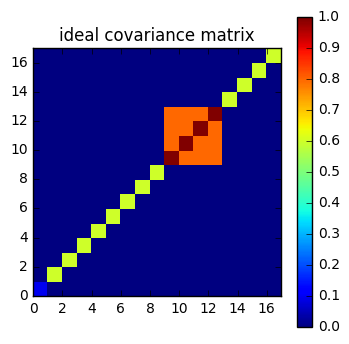

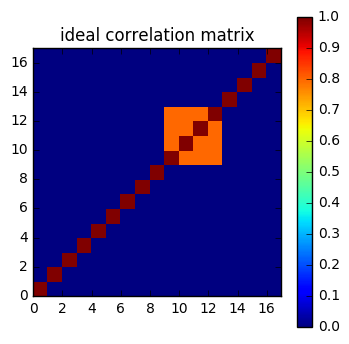

In [6]:
# ideal covariance matrix
ideal_cov = np.zeros([n_C,n_C])
ideal_cov = np.eye(n_C)*0.6
ideal_cov[0,0] = 0.1
ideal_cov[9:13,9:13] = 0.8
for cond in range(9,13):
    ideal_cov[cond,cond] = 1

fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(ideal_cov)
plt.colorbar()
plt.xlim([0,17])
plt.ylim([0,17])
ax = plt.gca()
ax.set_aspect(1)
plt.title('ideal covariance matrix')
plt.show()

std_diag = np.diag(ideal_cov)**0.5
ideal_corr = ideal_cov / std_diag / std_diag[:,None]
fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(ideal_corr)
plt.colorbar()
plt.xlim([0,17])
plt.ylim([0,17])
ax = plt.gca()
ax.set_aspect(1)
plt.title('ideal correlation matrix')
plt.show()

#### In the following, pseudo-SNR is generated from a Gaussian process defined on a "linear" ROI, just for simplicity of code

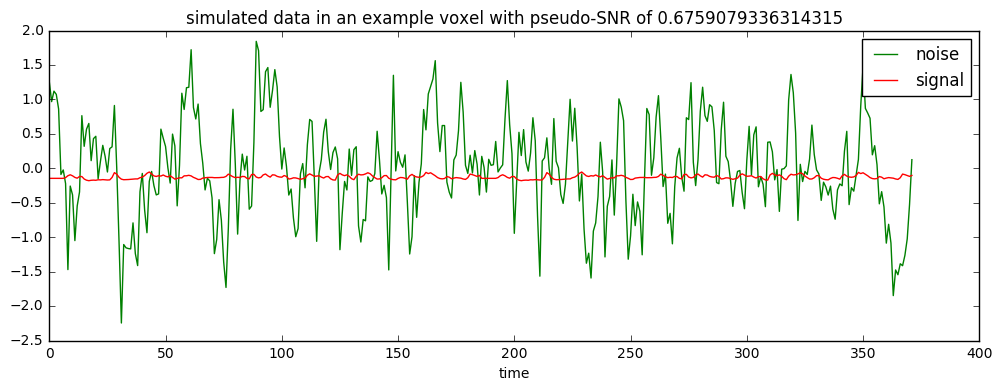

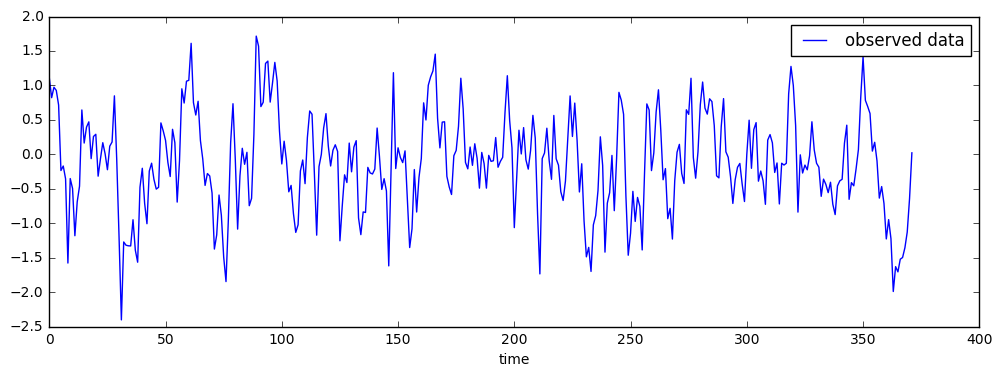

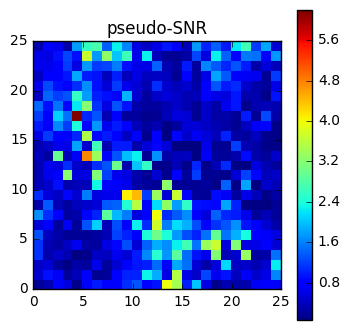

In [7]:


L_full = np.linalg.cholesky(ideal_cov)        

# generating signal
snr_level = 0.5
# Notice that accurately speaking this is not snr. the magnitude of signal depends
# not only on beta but also on x. (noise_level*snr_level)**2 is the factor multiplied
# with ideal_cov to form the covariance matrix from which the response amplitudes (beta)
# of a voxel are drawn from.

tau = 0.8
# magnitude of Gaussian Process from which the log(SNR) is drawn
smooth_width = 3.0
# spatial length scale of the Gaussian Process, unit: voxel
inten_kernel = 4.0
# intensity length scale of the Gaussian Process
# Slightly counter-intuitively, if this parameter is very large,
# say, much larger than the range of intensities of the voxels,
# then the smoothness has much small dependency on the intensity.


# coords = np.arange(0,n_V)[:,None]
# our "ROI" is a "long line" of voxels
coords = np.mgrid[0:ROI_edge, 0:ROI_edge, 0:1]
coords_flat = np.reshape(coords,[3, n_V]).T
dist2 = spdist.squareform(spdist.pdist(coords_flat, 'sqeuclidean'))

inten = np.random.rand(n_V) * 20.0
# For simplicity, we just assume that the intensity of all voxels are uniform distributed between 0 and 20
# parameters of Gaussian process to generate pseuso SNR
# For curious user, you can also try the following commond
# to see what an example snr map might look like if the intensity
# grows linearly in one spatial direction

# inten = coords_flat[:,0] * 2


inten_tile = np.tile(inten,[n_V,1])
inten_diff2 = (inten_tile-inten_tile.T)**2

K = np.exp(-dist2/smooth_width**2/2.0 -inten_diff2/inten_kernel**2/2.0) * tau**2 \
    + np.eye(n_V)*tau**2*0.001
# A tiny amount is added to the diagonal of the GP covariance matrix to make sure it can be inverted
L = np.linalg.cholesky(K)
snr = np.exp(np.dot(L,np.random.randn(n_V))) * snr_level
sqrt_v = noise_level*snr
betas_simulated = np.dot(L_full,np.random.randn(n_C,n_V)) * sqrt_v
signal = np.dot(design.design_used,betas_simulated)


Y = signal + noise
# The data to be fed to the program.


idx = np.argmin(np.abs(snr-np.median(snr)))
# choose a voxel of medium level SNR.
fig = plt.figure(num=None, figsize=(12, 4), dpi=150, facecolor='w', edgecolor='k')
noise_plot, = plt.plot(noise[:,idx],'g')
signal_plot, = plt.plot(signal[:,idx],'r')
plt.legend([noise_plot, signal_plot], ['noise', 'signal'])
plt.title('simulated data in an example voxel with pseudo-SNR of {}'.format(snr[idx]))
plt.xlabel('time')
plt.show()

fig = plt.figure(num=None, figsize=(12, 4), dpi=150, facecolor='w', edgecolor='k')
data_plot, = plt.plot(Y[:,idx],'b')
plt.legend([data_plot], ['observed data'])
plt.xlabel('time')
plt.show()

fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(np.reshape(snr, [ROI_edge, ROI_edge]))
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
plt.title('pseudo-SNR')
plt.show()

#### The reason that the pseudo-SNR in the example voxel is not too small, while the signal looks much smaller is because we happen to have low amplitudes in our design matrix. The True SNR depends on both the amplitudes in design matrix and the pseudo-SNR. Therefore, be aware that pseudo-SNR does not directly reflects how much signal the data have, but rather a map indicating the relative strength of signal in differerent voxels.

#### When you have multiple runs, the noise won't be correlated between runs. Therefore, you should tell BRSA when is the onset of each scan

In [8]:
scan_onsets = np.linspace(0,design.n_TR,num=3)[:-1]
print('scan onsets: {}'.format(scan_onsets))

scan onsets: [   0.  186.]


# (2) Fit Bayesian RSA to our simulated data

In [9]:
brsa = BRSA(GP_space=True,GP_inten=True)
# Initiate an instance, telling it that we want to impose Gaussian Process prior over both space and intensity.

brsa.fit(X=Y, design=design.design_used, scan_onsets=scan_onsets,
         coords=coords_flat, inten=inten)
# The data to fit should be given to the argument X. Design matrix goes to design. And so on.


BRSA(GP_inten=True, GP_space=True, epsilon=0.0001, init_iter=20,
   inten_smooth_range=None, n_iter=50, optimizer='BFGS', pad_DC=False,
   rand_seed=0, rank=None, space_smooth_range=None, tau_range=5.0,
   tol=0.002, verbose=False)

### We can have a look of the estimated similarity in matrix brsa.C_ 

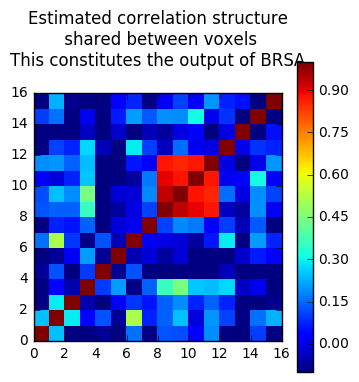

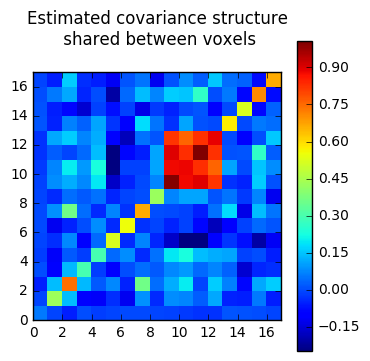

In [10]:
fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(brsa.C_[1:, 1:], vmin=-0.1, vmax=1)
plt.xlim([0, 16])
plt.ylim([0, 16])
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
plt.title('Estimated correlation structure\n shared between voxels\n'
         'This constitutes the output of BRSA\n')
plt.show()

fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(brsa.U_)
plt.xlim([0, 17])
plt.ylim([0, 17])
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
plt.title('Estimated covariance structure\n shared between voxels\n')
plt.show()

## In contrast, we can have a look of the similarity matrix based on Pearson correlation between point estimates of betas of different conditions.
## This is what vanila RSA might give

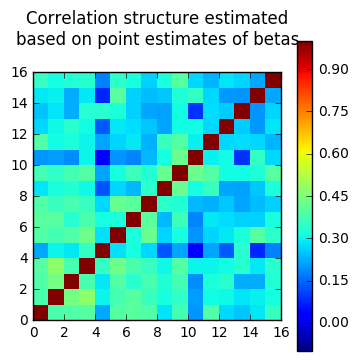

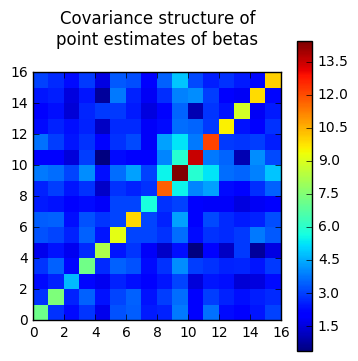

In [11]:
betas_point = np.linalg.lstsq(design.design_used, Y)[0]
point_corr = np.corrcoef(betas_point)
point_cov = np.cov(betas_point) 
fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(point_corr[1:, 1:], vmin=-0.1, vmax=1)
plt.xlim([0, 16])
plt.ylim([0, 16])
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
plt.title('Correlation structure estimated\n'
         'based on point estimates of betas\n')
plt.show()

fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(point_cov[1:, 1:])
plt.xlim([0, 16])
plt.ylim([0, 16])
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
plt.title('Covariance structure of\n'
         'point estimates of betas\n')
plt.show()

### We can make a comparison between the estimated SNR map and the true SNR map (normalized)

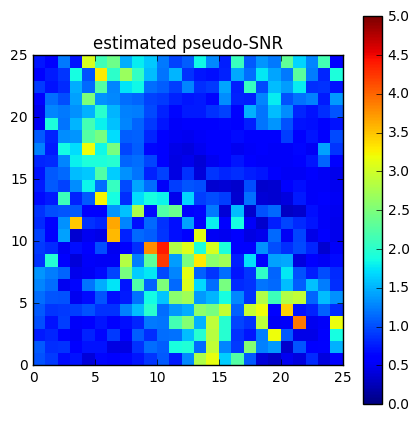

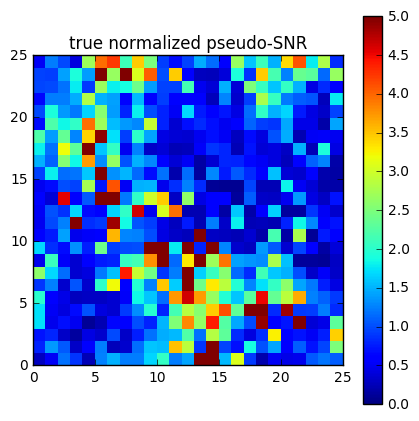

In [12]:
fig = plt.figure(num=None, figsize=(5, 5), dpi=100)
plt.pcolor(np.reshape(brsa.nSNR_, [ROI_edge, ROI_edge]), vmin=0, vmax=5)
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
ax.set_title('estimated pseudo-SNR')
plt.show()

fig = plt.figure(num=None, figsize=(5, 5), dpi=100)
plt.pcolor(np.reshape(snr / np.exp(np.mean(np.log(snr))), [ROI_edge, ROI_edge]), vmin=0, vmax=5)
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
ax.set_title('true normalized pseudo-SNR')
plt.show()

In [13]:
RMS_BRSA = np.mean((brsa.C_[1:,1:] - ideal_corr[1:,1:])**2)**0.5
RMS_RSA = np.mean((point_corr[1:,1:] - ideal_corr[1:,1:])**2)**0.5
print('RMS error of Bayesian RSA: {}'.format(RMS_BRSA))
print('RMS error of standard RSA: {}'.format(RMS_RSA))
print('Recovered spatial smoothness length scale: {}, vs. true value: {}'.format(brsa.lGPspace_, smooth_width))
print('Recovered intensity smoothness length scale: {}, vs. true value: {}'.format(brsa.lGPinten_, inten_kernel))
print('Recovered standard deviation of GP prior: {}, vs. true value: {}'.format(brsa.bGP_, tau))

RMS error of Bayesian RSA: 0.16314814342719455
RMS error of standard RSA: 0.30481413363402166
Recovered spatial smoothness length scale: 4.663104518767732, vs. true value: 3.0
Recovered intensity smoothness length scale: 7.520403036422732, vs. true value: 4.0
Recovered standard deviation of GP prior: 0.3552005519508863, vs. true value: 0.8


#### Empirically, the smoothness turns to be over-estimated when signal is weak.